# Training analysis for DeepRacer

https://github.com/aws-deepracer-community/deepracer-analysis

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

In [1]:
# Make sure you have deepracer-utils >= 0.9

# import sys

# !{sys.executable} -m pip install --upgrade deepracer-utils

## Imports

Run the imports block below:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

## Load waypoints for the track you want to run analysis on

The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [3]:
tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

NameError: name 'TrackIO' is not defined

Now let's load the track:

Loaded 238 waypoints


<AxesSubplot: >

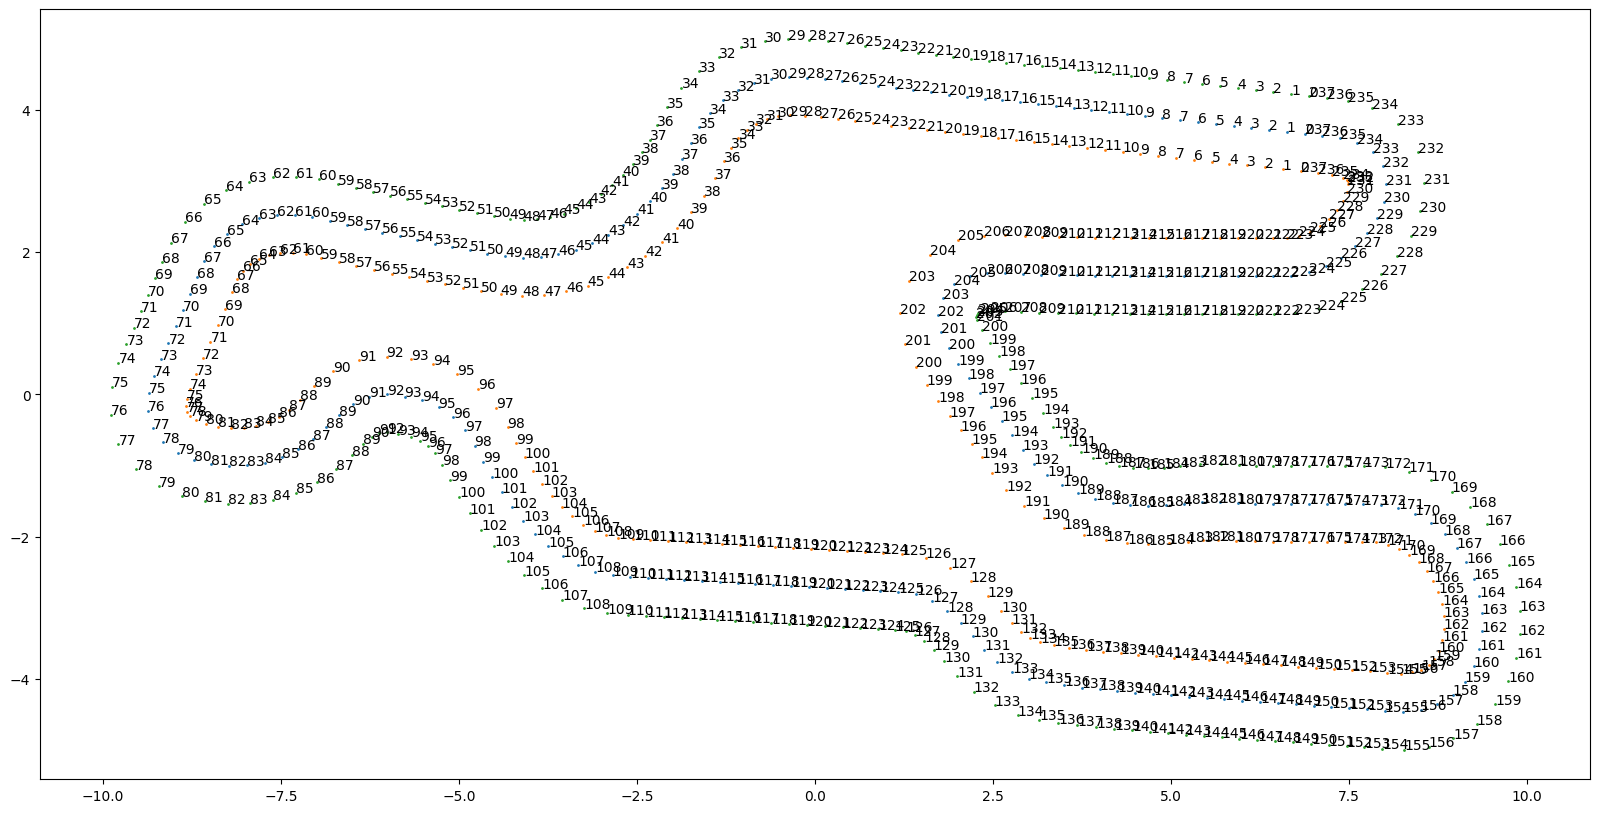

In [ ]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "arctic_pro"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

# X and Y Reward Analysis

In [ ]:
# TODO: optimize density

import numpy as np
from math import floor
import pandas as pd

def populate_square(x_original, y_original, density=6):
    '''this function is used later on sorry for the poor documentation'''

    x = []
    y = []

    x.append(np.linspace(x_original[0], x_original[3], num=density+2)[1:-1])
    y.append(np.linspace(y_original[0], y_original[3], num=density+2)[1:-1])

    x.append(np.linspace(x_original[1], x_original[2], num=density+2)[1:-1])
    y.append(np.linspace(y_original[1], y_original[2], num=density+2)[1:-1])

    temp_x = []
    temp_y = []

    # optimize this modify the num to be dynamic
    for idx in range(density):
        # print((floor(abs(idx-(density/2)))))
        temp_x.append(np.linspace(x[0][idx], x[1][idx], num=(density))[1:-1])
        temp_y.append(np.linspace(y[0][idx], y[1][idx], num=(density))[1:-1])

    # optimize this modify the num to be dynamic
    for idx in range(density):
        temp_x.append(np.linspace(x[0][idx], x[1][density-idx-1], num=(density))[1:-1])
        temp_y.append(np.linspace(y[0][idx], y[1][density-idx-1], num=(density))[1:-1])

    temp_x = list(np.array(x).flat) + list(np.array(temp_x).flat)
    temp_y = list(np.array(y).flat) + list(np.array(temp_y).flat)

    final_x = []
    final_y = []

    for idx in range(len(temp_x)):
        in_there = False
        for i in range(len(final_x)):
            if round(temp_x[idx], 2) == round(final_x[i],2) and round(temp_y[idx],2) == round(final_y[i],2):
                in_there = True
                break
        if not in_there:
            final_x.append(temp_x[idx])
            final_y.append(temp_y[idx])


    return final_x, final_y

In [ ]:
# TODO: optimize this to have bins to shorten the compute time
def split_data(x, y, reward, round_reward_digits=2):

    reward = [round(i, round_reward_digits) for i in reward]

    unique = set(reward)

    X = []
    Y = []
    reward_out = []

    for reward_value in unique:
        X_temp = []
        Y_temp = []
        for j in range(len(x)):
            if reward_value == reward[j]:
                X_temp.append(x[j])
                Y_temp.append(y[j])

        reward_out.append([reward_value for x in range(len(X_temp))])
        X.append(X_temp)
        Y.append(Y_temp)

    return X, Y, reward_out
    

# reward function

In [ ]:
# change reward_function_sample to your own .py file with a reward function (i recommend the name reward_function.py)
from reward_function_sample import reward_function

# reward analysis

In [ ]:
# change DENSITY if to adjust the number of points computed (higher is more points)
DENSITY = 7

# could use subset of the points to focus on that section
track.waypoints = track.waypoints#[0:20]

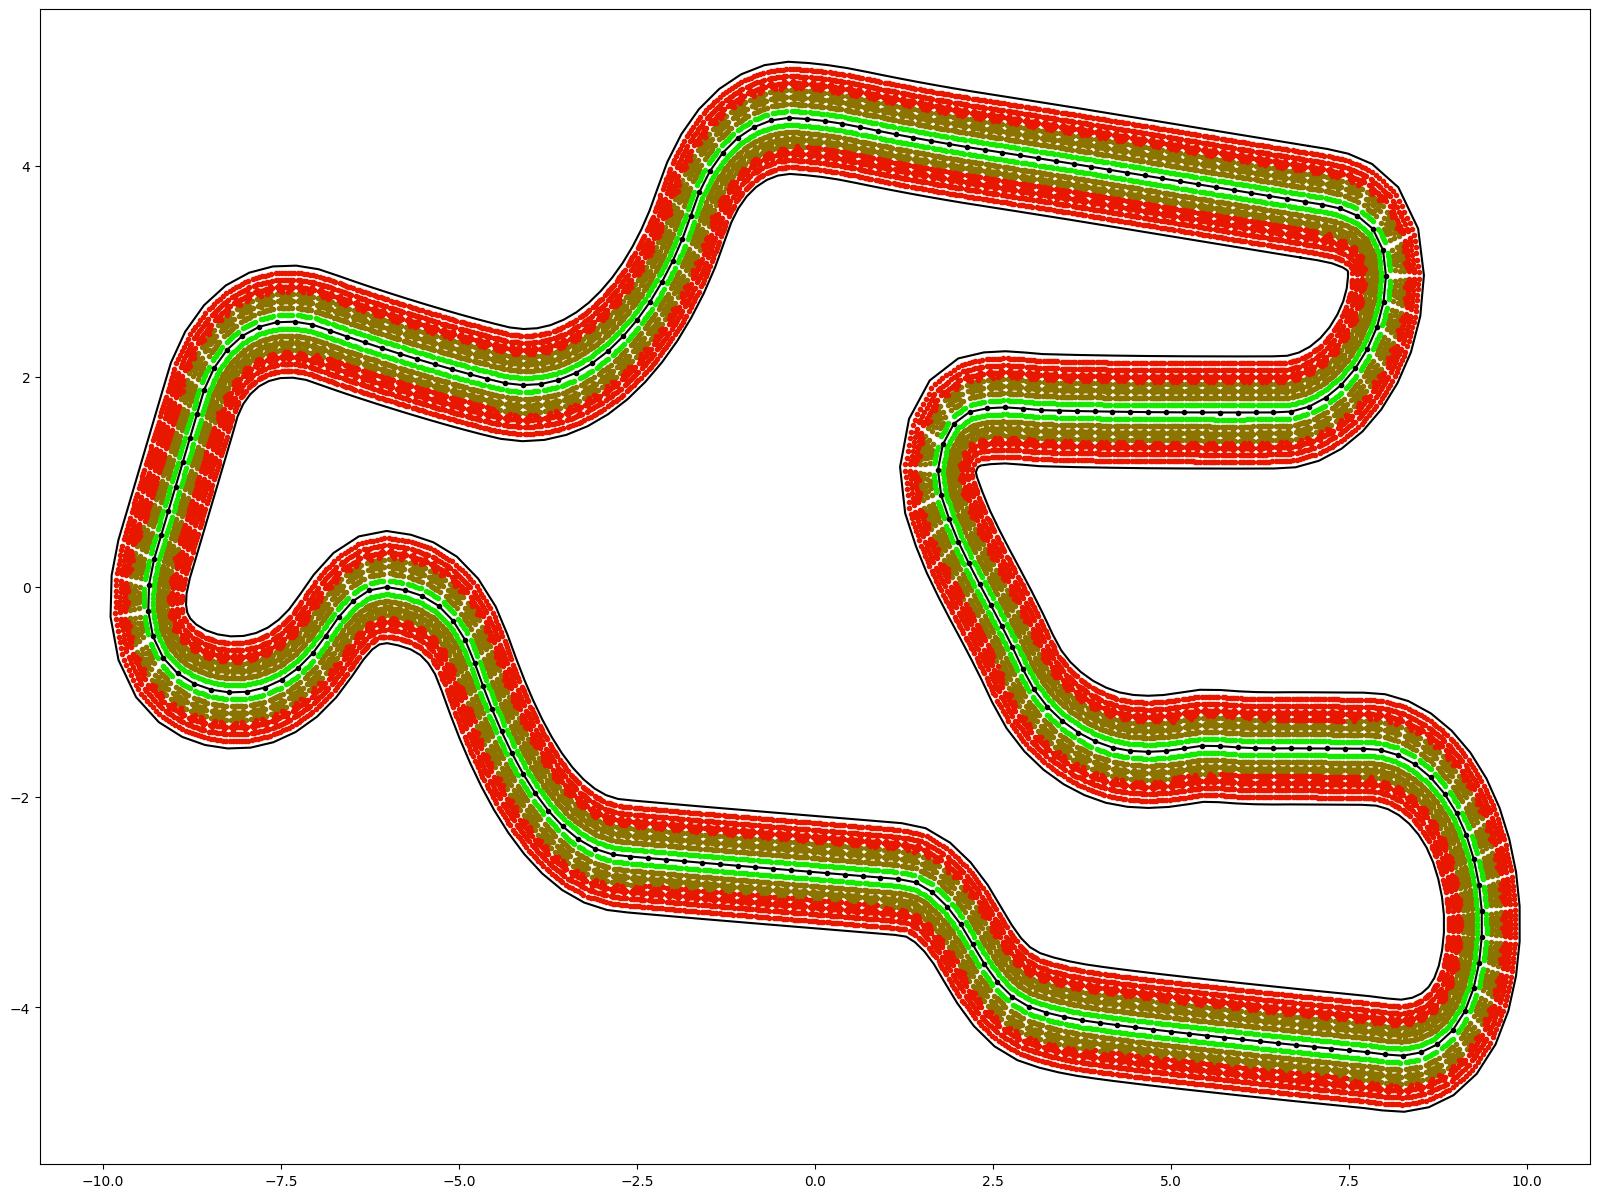

In [ ]:
from matplotlib.pyplot import figure
import math

plt.figure(figsize=(20, 15))

# waypoint_idx = 0
MAX = len(track.waypoints)

X = []
Y = []
reward = []

params = {"all_wheels_on_track": True,
          "track_width": ((track.waypoints[0][2] - track.waypoints[0][4])**2 + (track.waypoints[0][3] - track.waypoints[0][5])**2)**0.5,
          "waypoints": [[x[0], x[1]] for x in track.waypoints],
          "speed": 0.5,
          "steering_angle": 5}

for idx, waypoint in enumerate(track.waypoints):
    if (idx == len(track.waypoints)-1):
        break
    # ONLY INSIDE SIDE OF THE TRACK -----------------------------------------
    x = [track.waypoints[idx][0], track.waypoints[idx][2], track.waypoints[(idx+1)%MAX][0], track.waypoints[(idx+1)%MAX][2]]
    y = [track.waypoints[idx][1], track.waypoints[idx][3], track.waypoints[(idx+1)%MAX][1], track.waypoints[(idx+1)%MAX][3]]

    X_temp, Y_temp = populate_square(x,y, density=DENSITY)

    for location_idx in range(len(X_temp)):
        # print(f'location_idx: {location_idx} left: {True}, X_temp: {X_temp[location_idx]}, Y_temp: {Y_temp[location_idx]}, closet_waypoint: {[idx, (idx+1)%MAX]}')
        params["is_left_of_center"] = True
        params["x"] = X_temp[location_idx]
        params["y"] = Y_temp[location_idx]
        params["closest_waypoints"] = [idx, (idx+1)%MAX]

        # distance from centre
        angle1 = math.atan(
                    (Y_temp[location_idx]-track.waypoints[idx][1]+1e-4)
                    /(X_temp[location_idx]-track.waypoints[idx][0]+1e-4) 
                )

        cur_angle = math.atan(
                    (track.waypoints[(idx+1)%MAX][1]-track.waypoints[idx][1]+1e-4)
                    /(track.waypoints[(idx+1)%MAX][0]-track.waypoints[idx][0]+1e-4) 
                ) * 180/3.1415

        distance_from_center = abs(math.sin(cur_angle*(3.1415/180)-angle1)
                            * (math.sqrt((Y_temp[location_idx]-track.waypoints[idx][1])**2 + (X_temp[location_idx]-track.waypoints[idx][0])**2)))

        params["distance_from_center"] = distance_from_center
        reward += [reward_function(params)]
        
    
    X = X + X_temp
    Y = Y + Y_temp


    # ONLY OUTSIDE SIDE OF THE TRACK ---------------------------------------
    x = [track.waypoints[idx][0], track.waypoints[idx][4], track.waypoints[(idx+1)%MAX][0], track.waypoints[(idx+1)%MAX][4]]
    y = [track.waypoints[idx][1], track.waypoints[idx][5], track.waypoints[(idx+1)%MAX][1], track.waypoints[(idx+1)%MAX][5]]

    X_temp, Y_temp = populate_square(x,y, density=DENSITY)

    for location_idx in range(len(X_temp)):
        params["is_left_of_center"] = False
        params["x"] = X_temp[location_idx]
        params["y"] = Y_temp[location_idx]
        params["closest_waypoints"] = [idx, (idx+1)%MAX]

        # distance from centre
        angle1 = math.atan(
                    (Y_temp[location_idx]-track.waypoints[idx][1]+1e-4)
                    /(X_temp[location_idx]-track.waypoints[idx][0]+1e-4) 
                )

        cur_angle = math.atan(
                    (track.waypoints[(idx+1)%MAX][1]-track.waypoints[idx][1]+1e-4)
                    /(track.waypoints[(idx+1)%MAX][0]-track.waypoints[idx][0]+1e-4)
                ) * 180/3.1415

        distance_from_center = abs(math.sin(cur_angle*(3.1415/180)-angle1)
                            * (math.sqrt((Y_temp[location_idx]-track.waypoints[idx][1])**2 + (X_temp[location_idx]-track.waypoints[idx][0])**2)))

        params["distance_from_center"] = distance_from_center

        reward += [reward_function(params)]

    X = X + X_temp
    Y = Y + Y_temp

MAX_reward = max(reward)+0.1    # FIXME: need the +0.1 due to the round() in split_data

X,Y,reward = split_data(X,Y,reward, round_reward_digits=1)

# the standard track
plt.plot([i[2] for i in track.waypoints],[i[3] for i in track.waypoints], color='black')
plt.plot([i[4] for i in track.waypoints],[i[5] for i in track.waypoints], color='black')
plt.plot([i[0] for i in track.waypoints],[i[1] for i in track.waypoints], color='black', marker='.')

# the filled points # TODO: an limit to show only the lowest scores and such
for idx in range(len(reward)):
    try:
        plt.scatter(X[idx],Y[idx], color=[(MAX_reward-reward[idx][0])/MAX_reward, reward[idx][0]/MAX_reward, 0, 1], marker='.')
    except:
        print([(MAX_reward-reward[idx][0])/MAX_reward, reward[idx][0]/MAX_reward, 0, 1])

# # uncomment if you want to zoom in on a certain section
# plt.xlim([-8.5, -2.5])
# plt.ylim([-2, 2])
# plt.show()